In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


In [ ]:
# importing the necessary packages
import torch

import matplotlib.pyplot as plt

from torch import nn
from torch import optim
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import transforms
from torchvision.datasets.mnist import FashionMNIST

# import  diffusion model
from A5_diffusion_submission import VarianceScheduler
from A5_diffusion_submission import NoiseEstimatingNet
from A5_diffusion_submission import DiffusionModel
from A5_diffusion_submission import load_diffusion_and_generate

In [ ]:
# loading dataset
kwargs = {'root':'datasets/FashionMNIST',
          'train':True,
          'transform':transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: 2 * x - 1.)]),
          'download':True}

train_dataset = FashionMNIST(**kwargs)

train_dataset, val_dataset = random_split(train_dataset, [len(train_dataset) - 12000, 12000])

48000 12000
(28, 28, 1)


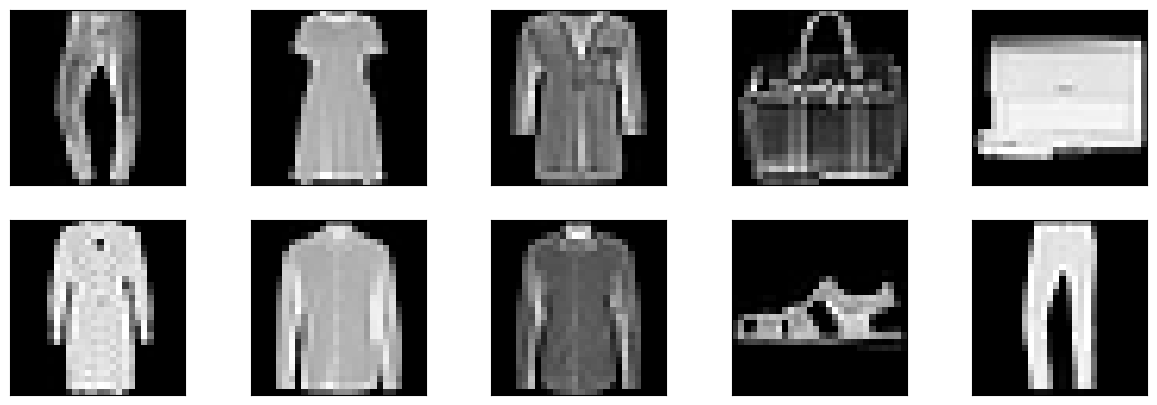

In [ ]:
# showing the dataset
print(len(train_dataset), len(val_dataset))

sample_images = [train_dataset[i][0].permute(1, 2, 0).numpy() for i in range(10)]
print(sample_images[0].shape)
fig, ax = plt.subplots(2, 5)
fig.set_size_inches(15, 5)
for i in range(2):
    for j in range(5):
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        ax[i, j].imshow(sample_images[i * 5 + j], cmap='gray')
plt.show()

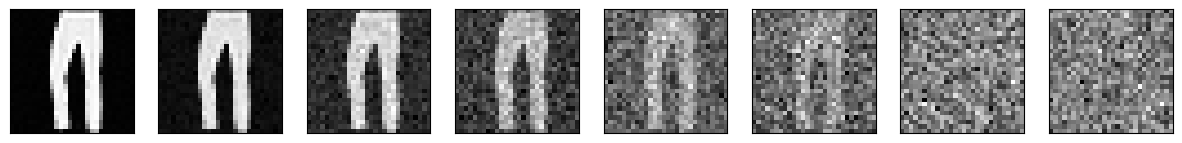

In [ ]:
# testing the variance scheduler

var_schd = VarianceScheduler(num_steps=1000)

sample_image = train_dataset[0][0].unsqueeze(0)

noise_levels = [0, 10, 50, 100, 200, 300, 600, 999]

fig, ax = plt.subplots(1, 8)
fig.set_size_inches(15, 10)
for i in range(8):
  ax[i].set_xticks([])
  ax[i].set_yticks([])
  ax[i].imshow(var_schd.add_noise(sample_image, torch.tensor(noise_levels[i]))[0].squeeze(0).permute(1, 2, 0).numpy(), cmap='gray')
plt.show()

In [ ]:
def train(diffusion_model: DiffusionModel,
          train_loader: DataLoader,
          val_loader: DataLoader,
          optimizer: optim,
          epochs: int,
          device=torch.device('cuda'),
          display_interval: int=5):


  itrs = tqdm(range(epochs))
  itrs.set_description('Train Loss: ? - Val Loss: ?')

  best_loss = float('inf')
  for epoch in itrs:
    avg_train_loss = 0.
    for sample in train_loader:
      x = sample[0].to(device)
      label = sample[1].type(torch.long).to(device)

      optimizer.zero_grad()

      loss = diffusion_model(x, label)

      loss.backward()
      optimizer.step()

      avg_train_loss += loss.item()

    avg_train_loss /= len(train_loader)

    # validating and saving the model
    with torch.no_grad():
      avg_val_loss = 0.
      for sample in val_loader:
        x = sample[0].to(device)
        label = sample[1].type(torch.long).to(device)

        loss = diffusion_model(x, label)

        avg_val_loss += loss.item()

      avg_val_loss /= len(val_loader)

    itrs.set_description(f'Train Loss: {avg_train_loss:.3f} - Val Loss: {avg_val_loss:.3f}')

    # saving the model on the best validation loss
    if best_loss > avg_val_loss:
      best_loss = avg_val_loss
      torch.save(diffusion_model.state_dict(), 'diffusion.pt')

    if display_interval is not None:
      if epoch % display_interval == 0 or epoch == epochs - 1:
        # generating some sample to see the quality of the generative model
        samples = diffusion_model.generate_sample(10, torch.arange(10).cuda(), torch.device('cuda'))
        fig, ax = plt.subplots(1, 10)
        fig.set_size_inches(15, 10)
        for i in range(10):
          ax[i].set_xticks([])
          ax[i].set_yticks([])
          ax[i].imshow(samples[i].cpu().permute(1, 2, 0).numpy(), cmap='gray')
        plt.show()

Train Loss: 0.214 - Val Loss: 0.098:   0%|          | 0/10 [00:18<?, ?it/s]

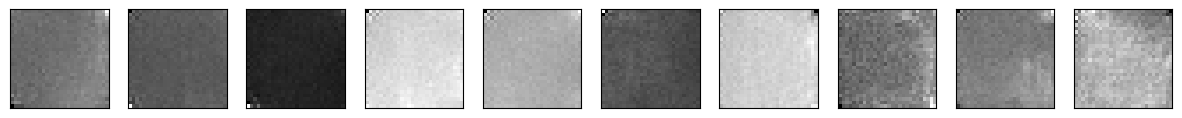

Train Loss: 0.059 - Val Loss: 0.057:  50%|█████     | 5/10 [01:52<01:31, 18.26s/it]

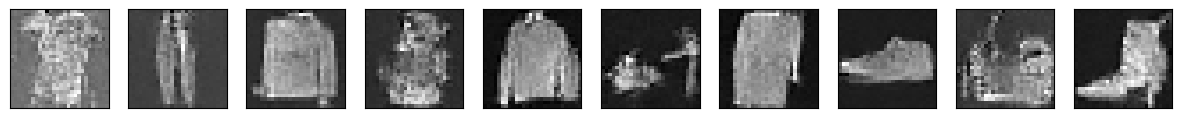

Train Loss: 0.054 - Val Loss: 0.053:  90%|█████████ | 9/10 [03:09<00:18, 18.67s/it]

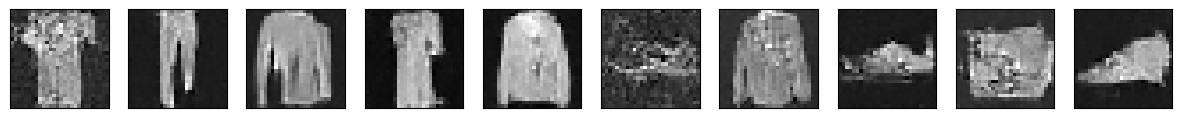

Train Loss: 0.054 - Val Loss: 0.053: 100%|██████████| 10/10 [03:14<00:00, 19.49s/it]


In [ ]:
# Training the diffusion model
# Do NOT run this block since the model is already trained and its state is saved in the .pt file
# Run the next three blocks to generate samples and view classification results





# setting the configurations
# NOTE: to train VAE, it is necessary to specify values for num_steps, batch_size, etc.
device = torch.device('cuda')
num_steps = None 
batch_size = None # defining batch size
lr = None # specify learning rate
epochs = 10 
num_classes = 10
display_interval = 5 

# defining the diffusion model component nets
var_scheduler = None # defining variance scheduler
noise_net = None #defining  noise estimating network

# loading a train and validation data
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# defining the diffusion model
diffusion = DiffusionModel(noise_net, var_scheduler).to(device)

optimizer = optim.Adam(diffusion.parameters(), lr) # specify the optimizer; e.g. optim.Adam(diffusion.parameters(), lr)

# training the diffusion model
train(diffusion_model=diffusion,
      train_loader=train_loader,
      val_loader=val_loader,
      optimizer=optimizer,
      epochs=epochs,
      device=device,
      display_interval=display_interval)


In [ ]:
# a classifier trained on FashionMNIST
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc1 = nn.Linear(in_features=64*7*7, out_features=600)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)

        return out

In [ ]:
device = torch.device('cuda')
diffusion=DiffusionModel(NoiseEstimatingNet(),VarianceScheduler())

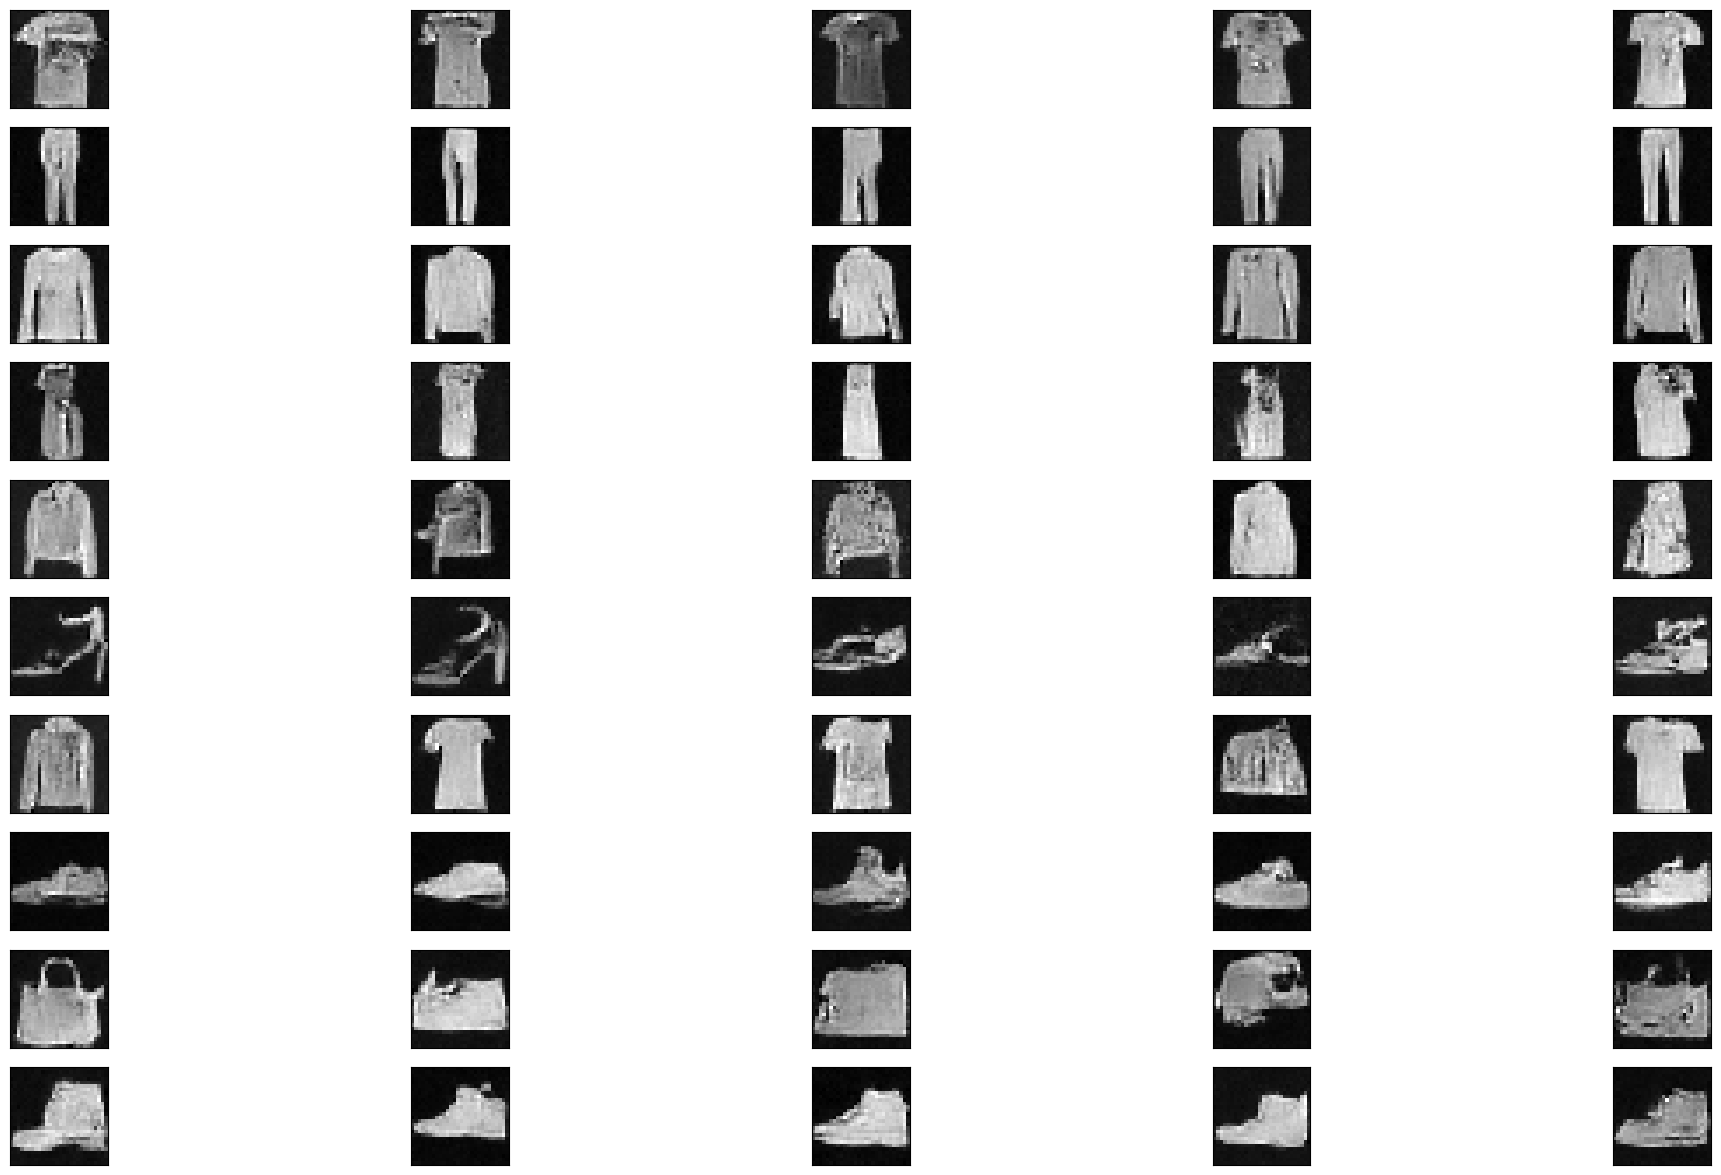

tensor([0, 6, 0, 0, 0, 1, 1, 1, 1, 1, 2, 4, 4, 6, 2, 3, 3, 3, 3, 6, 4, 4, 4, 2,
        6, 5, 5, 5, 5, 5, 4, 6, 6, 6, 0, 7, 7, 7, 5, 7, 8, 8, 8, 0, 8, 9, 9, 9,
        9, 9], device='cuda:0')
78.00


In [ ]:
# The classifier is used to see if how well we can classify the generated images
# generate 5 samples from each class
desired_labels = []
for i in range(10):
    for _ in range(5):
        desired_labels.append(i)

desired_labels = torch.tensor(desired_labels).to(device)

# loading the diffusion model

diffusion.load_state_dict(torch.load('diffusion.pt'))
diffusion = diffusion.to(device)

# generating samples from the Diffusion
generated_samples = load_diffusion_and_generate()

# normalizing the results
min_per_batch = generated_samples.flatten(start_dim=1).min(dim=-1).values.reshape(-1, 1, 1, 1)
max_per_batch = generated_samples.flatten(start_dim=1).max(dim=-1).values.reshape(-1, 1, 1, 1)

generated_samples = (generated_samples - min_per_batch) / (max_per_batch - min_per_batch)

fig, ax = plt.subplots(10, 5)
fig.set_size_inches(25, 15)
for i in range(10):
    for j in range(5):
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        ax[i, j].imshow(generated_samples[i * 5 + j].permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.show()

classifier = Classifier().to(device)
classifier.load_state_dict(torch.load('classifier.pt'))

with torch.no_grad():
    preds = classifier(generated_samples)

preds = torch.argmax(preds, dim=-1)
acc = (preds == desired_labels).sum() / 50.

print(preds)
print(f'{acc.cpu().item() * 100:.2f}')